In [42]:
import os
import glob
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import math
import scipy.misc
from tqdm import tqdm

# we need to know original resolution, so img_path should be a location of original files
# benchmark image path may already cropped.
IMAGE_SRC_DIR = '/mnt/data_export/images/'
annot_path = '/home/phantom/projects/vision/phantomnet/datasets/phantom/Annotations'

seg_bench_root = '/media/phantom/World/phantom_benchmark'
out_gt_path = os.path.join(seg_bench_root, 'detection', 'gt.txt')
img_path = os.path.join(seg_bench_root, 'images')
imgfs = glob.glob(os.path.join(img_path, '*.png'))        # test set list


print('Building file locator..')
file_locator = {}
for root, dirs, files in os.walk(IMAGE_SRC_DIR):
    for file in files:
        if file[0] == '.': continue
        file_locator[file] = os.path.join(root, file)

Building file locator..


We need to change labels, because we only use `vehicle`, `cyclist`, `person`, `lane`, `road`. (For detection, only `vehicle` ~ `person`.)

In [54]:
# Here we adjust labels
label_map = {
    'none': (0, 'background'),
    'sedan': (1, 'vehicle'),
    'sedan-occluded': (1, 'vehicle'),
    'suv': (1, 'vehicle'),
    'suv-occluded': (1, 'vehicle'),
    'truck': (1, 'vehicle'),
    'truck-occluded': (1, 'vehicle'),
    'caravan': (1, 'vehicle'),
    'caravan-occluded': (1, 'vehicle'),
    'trailer': (1, 'vehicle'),
    'trailer-occluded': (1, 'vehicle'),
    'bus': (1, 'vehicle'),
    'bus-occluded': (1, 'vehicle'),
    'lane-dashed': (4, 'lane'),
    'lane-solid': (4, 'lane'),
    'lane-dotted': (4, 'lane'),
    'pedestrian': (3, 'person'),
    'free_space': (5, 'road'),
    'bicyclist': (2, 'cyclist'),
    'bicycle': (2, 'cyclist'),
    'motorcycle': (2, 'cyclist'),
    'motorcyclist': (2, 'cyclist'),
}
label_map = {key: label_map[key][1] for key in label_map}
print(label_map)

{'none': 'background', 'trailer-occluded': 'vehicle', 'lane-dashed': 'lane', 'truck-occluded': 'vehicle', 'suv-occluded': 'vehicle', 'bus-occluded': 'vehicle', 'sedan-occluded': 'vehicle', 'trailer': 'vehicle', 'bus': 'vehicle', 'caravan': 'vehicle', 'truck': 'vehicle', 'free_space': 'road', 'motorcycle': 'cyclist', 'pedestrian': 'person', 'suv': 'vehicle', 'bicyclist': 'cyclist', 'lane-dotted': 'lane', 'caravan-occluded': 'vehicle', 'lane-solid': 'lane', 'sedan': 'vehicle', 'bicycle': 'cyclist', 'motorcyclist': 'cyclist'}


(0.45586419753086388, 0.60792958033264743, 0.4746913580246912, 0.63591311942729756)
(0.42361111111111088, 0.61643438143004103, 0.44151234567901215, 0.63646181627229048)
(0.44243827160493809, 0.60820392875514362, 0.46697530864197523, 0.64277182998971139)
(0.39984479362581965, 0.60299207899305551, 0.42685096646532594, 0.64304694867755441)
(0.36319246645326952, 0.57773683650012853, 0.42083135534215838, 0.68185206283757682)
(0.1765624999999999, 0.55422889803662723, 0.34062500000000001, 0.77583383630823177)
(0.15069378746880419, 0.57938408243312733, 0.22407341709843384, 0.68720301247427973)
(0.46921228479455984, 0.5859661337770059, 0.51666598849826362, 0.66909370579346694)
(0.52569178828486673, 0.61025064099472692, 0.54328438087745945, 0.63494199901941861)
(0.53379364013671848, 0.61066216362847225, 0.55717326976634807, 0.64152636115933614)
(0.55022882532190365, 0.60202018831983029, 0.59606215865523704, 0.65839878914287497)
(0.56296030680338516, 0.59502430354616742, 0.59606215865523704, 0.64

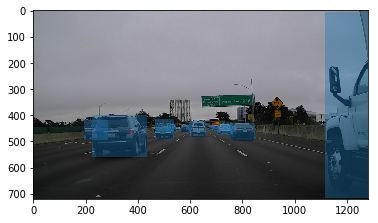

In [49]:
def create_gt(annotation_path, sz):
    with open(annotation_path, 'r') as jsf:
        data = json.load(jsf)

    items = data.get('markResult', [])
    gt = np.zeros(sz, np.uint8)
    
    im_width = float(sz[1])
    im_height = float(sz[0])
    bboxes = []
    labels = []
    
    for item in items:
        if item['type'] == 'Rect':
            label = item['extend']['currentDataKey']
            xs = [v['x'] for v in item['position']]
            ys = [v['y'] for v in item['position']]
            xmin = np.min(xs)
            xmax = np.max(xs)
            ymin = np.min(ys)
            ymax = np.max(ys)
            
            xmin = np.maximum(xmin, 0)
            ymin = np.maximum(ymin, 0)
            xmax = np.minimum(xmax, sz[1])
            ymax = np.minimum(ymax, sz[0])
            
            if xmin>=xmax or ymin>=ymax: continue
                
            #####
            # I do not like this part but .. it is decided.
            # height 720 cropping
            if ymin > 720: continue
            ymax = np.minimum(ymax, 720)
            #####
            
            labels.append(label)
            bboxes.append((xmin / im_width, ymin / im_height, xmax / im_width, ymax / im_height))
    return labels, bboxes

imgf = imgfs[10]
name = os.path.splitext(os.path.basename(imgf))[0]
annotf = os.path.join(annot_path, name + '.txt')

img = scipy.misc.imread(imgf)
assert(img.shape[:2] == (720, 1280))
labels, bboxes = create_gt(annotf, sz=img.shape[:2])

import matplotlib.patches as patches
def draw_box(img, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in bboxes:
        print(bbox)
        bbox = np.array(bbox)
        bbox[:2] *= [1280, 720]
        bbox[2:] *= [1280, 720]
        w = bbox[2]-bbox[0]
        h = bbox[3]-bbox[1]
        ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), w, h, alpha=0.4))
    plt.show()
    
draw_box(img, bboxes)

In [56]:
with open(out_gt_path, 'w') as fp:
    for imgf in tqdm(imgfs):
        name = os.path.splitext(os.path.basename(imgf))[0]
        annotf = os.path.join(annot_path, name + '.txt')

        img = scipy.misc.imread(imgf)
#         assert(img.shape[:2] == (720, 1280))
        if img.shape[:2] != (720, 1280): import pdb; pdb.set_trace()
        labels, bboxes = create_gt(annotf, sz=img.shape[:2])

        for label, bbx in zip(labels, bboxes):
            fp.write('%s %.3f %.3f %.3f %.3f %s\n' %
                (name, bbx[0], bbx[1], bbx[2], bbx[3], label_map[label.lower()]))


100%|██████████| 6426/6426 [03:15<00:00, 32.92it/s]
